Avvio analisi per trovare il numero ottimale di dimensioni (componenti PCA)...
Numero di feature 'pulite' prima della PCA: 39

--- Analisi Varianza Spiegata ---
Numero di componenti per spiegare l'80% della varianza: 15
Numero di componenti per spiegare il 90% della varianza: 21
Numero di componenti per spiegare il 95% della varianza: 26


(0.0, 39.0)

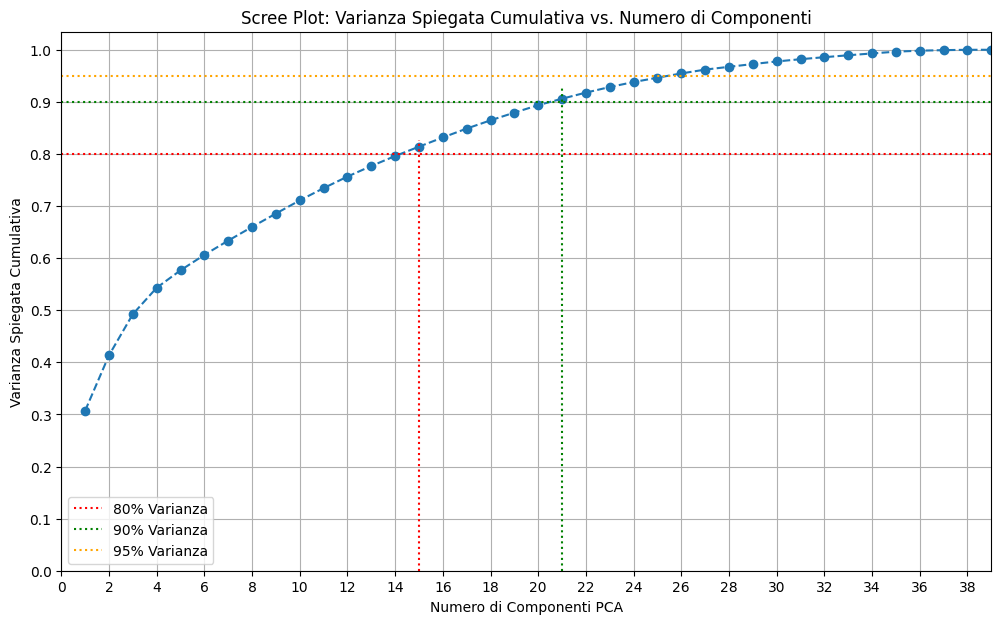

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

print("Avvio analisi per trovare il numero ottimale di dimensioni (componenti PCA)...")

# 1. Caricamento
df = pd.read_csv('data/puliti/movimento_fe.csv')

# 2. Definizione Feature (come da strategia vincente)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cols_to_exclude = [
    'ID', 'Jersey Number', 'Age', 'OVR', 'Potential', 'Special', 
    'International Reputation', 'Weak Foot', 'Skill Moves', 'Kit Number'
]
features_to_use = [col for col in numeric_cols if col not in cols_to_exclude]
X_all = df[features_to_use].fillna(df[features_to_use].mean())

# 3. Rimozione Ridondanze
corr_matrix = X_all.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]
final_features = [f for f in features_to_use if f not in to_drop]
print(f"Numero di feature 'pulite' prima della PCA: {len(final_features)}")

# 4. Filtro OVR (Top Players)
soglia_ovr = 75
df_top = df[df['OVR'] >= soglia_ovr].copy()
X_top = df_top[final_features].fillna(df_top[final_features].mean())

# 5. Scaling
scaler = StandardScaler()
X_top_scaled = scaler.fit_transform(X_top)

# 6. Esecuzione PCA 'Full'
# Eseguiamo la PCA tenendo TUTTE le componenti per analizzare la varianza
pca_full = PCA(n_components=None)
pca_full.fit(X_top_scaled)

# 7. Calcolo Varianza Cumulativa
explained_variance_ratio = pca_full.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# 8. Trovare i punti di soglia
components_for_80 = np.argmax(cumulative_explained_variance >= 0.80) + 1
components_for_90 = np.argmax(cumulative_explained_variance >= 0.90) + 1
components_for_95 = np.argmax(cumulative_explained_variance >= 0.95) + 1

print(f"\n--- Analisi Varianza Spiegata ---")
print(f"Numero di componenti per spiegare l'80% della varianza: {components_for_80}")
print(f"Numero di componenti per spiegare il 90% della varianza: {components_for_90}")
print(f"Numero di componenti per spiegare il 95% della varianza: {components_for_95}")

# 9. Creazione Grafico (Scree Plot)
plt.figure(figsize=(12, 7))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')

# Aggiungiamo le linee di soglia
plt.axhline(y=0.80, color='r', linestyle=':', label='80% Varianza')
plt.axhline(y=0.90, color='g', linestyle=':', label='90% Varianza')
plt.axhline(y=0.95, color='orange', linestyle=':', label='95% Varianza')

# Aggiungiamo le linee verticali per i punti trovati
plt.axvline(x=components_for_80, color='r', linestyle=':', ymax=0.80)
plt.axvline(x=components_for_90, color='g', linestyle=':', ymax=0.90)

plt.title('Scree Plot: Varianza Spiegata Cumulativa vs. Numero di Componenti')
plt.xlabel('Numero di Componenti PCA')
plt.ylabel('Varianza Spiegata Cumulativa')
plt.legend(loc='best')
plt.grid(True)
plt.yticks(np.arange(0, 1.1, 0.1)) # Ticks sull'asse Y per chiarezza
plt.xticks(range(0, len(cumulative_explained_variance)+1, 2)) # Ticks sull'asse X
plt.xlim(0, len(final_features)) # Limita l'asse X al numero massimo di feature
